**Overview**

Vincoli:
- Modello Globale che catturi la dipendenza tra le serie storiche -> Con LightGBM che è un modello globale e verrà fittato su dati che derivano da tutte le serie per il k-esimo step da prevedere
- Strategia Direct: OK
- Multiple serie storiche con un indice (panel data): il problema principale è che dopo aver creato i panel data, le features vengono calcolate senza tenere conto che le serie temporali sono indipendenti. Infatti, le features laggate presentano un overlap che non dovrebbe esserci. 
- Serie multivariate con più regressori
- Regressori esatti nel futuro ed altri che possono fermarsi al t corrente

In [35]:
# Libraries
# ==============================================================================
import pandas as pd
from lightgbm import LGBMRegressor
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.datasets import fetch_dataset
import matplotlib.pyplot as plt

In [36]:
# Download data
# ==============================================================================
data = fetch_dataset("h2o_exog")
data['ID'] = 1
data = data.asfreq('MS')
data = data.reset_index().rename({'fecha': 'ds'}, axis = 1).set_index('ds')
data.head()

h2o_exog
--------
Monthly expenditure ($AUD) on corticosteroid drugs that the Australian health
system had between 1991 and 2008. Two additional variables (exog_1, exog_2) are
simulated.
Hyndman R (2023). fpp3: Data for Forecasting: Principles and Practice (3rd
Edition). http://pkg.robjhyndman.com/fpp3package/,
https://github.com/robjhyndman/fpp3package, http://OTexts.com/fpp3.
Shape of the dataset: (195, 3)


,y,exog_1,exog_2,ID
ds,,,,
1992-04-01,0.379808,0.958792,1.166029,1
1992-05-01,0.361801,0.951993,1.117859,1
1992-06-01,0.410534,0.952955,1.067942,1
1992-07-01,0.483389,0.958078,1.097376,1
1992-08-01,0.475463,0.956370,1.122199,1


In [37]:
data_2 = data.copy()
data_2['y'] = data_2['y'] + 1
data_2['exog_1'] = data_2['exog_1'] + 0.01
data_2['exog_2'] = data_2['exog_2'] + 0.01
data_2['ID'] = 2
data_2.head()

,y,exog_1,exog_2,ID
ds,,,,
1992-04-01,1.379808,0.968792,1.176029,2
1992-05-01,1.361801,0.961993,1.127859,2
1992-06-01,1.410534,0.962955,1.077942,2
1992-07-01,1.483389,0.968078,1.107376,2
1992-08-01,1.475463,0.966370,1.132199,2


In [38]:
data = pd.concat([data, data_2])
data.head()

,y,exog_1,exog_2,ID
ds,,,,
1992-04-01,0.379808,0.958792,1.166029,1
1992-05-01,0.361801,0.951993,1.117859,1
1992-06-01,0.410534,0.952955,1.067942,1
1992-07-01,0.483389,0.958078,1.097376,1
1992-08-01,0.475463,0.956370,1.122199,1


In [39]:
# Data preprocessing
# ==============================================================================
# data.index.name = 'date'
steps = 3

data_train, data_test = [], []

for _, g in data.groupby('ID'):
    data_train.append(g.iloc[:-steps, :])
    data_test.append(g.iloc[-steps:, :])

data_train = pd.concat(data_train)
data_test = pd.concat(data_test)    

In [40]:
data_train.index.max(), data_test.index.min()

(Timestamp('2008-03-01 00:00:00'), Timestamp('2008-04-01 00:00:00'))

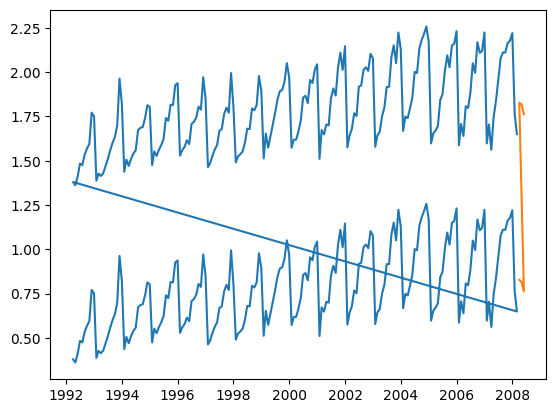

In [41]:
plt.plot(data_train['y'])
plt.plot(data_test['y'])

In [61]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterAutoregDirect(
                 regressor       = LGBMRegressor(random_state=123, verbose=-1),
                 lags            = 8,
                 steps           = 3,
                #  differentiation = None,
                transformer_y	 = None,
                transformer_exog = None,
                 fit_kwargs = {'categorical_feature':'ID'}
             )

forecaster.fit(y=data_train['y'], exog=data_train[['exog_1', 'exog_2']])
forecaster

c:\Users\l.ravazzi\AppData\Local\anaconda3\envs\env_github\lib\site-packages\skforecast\utils\utils.py:1125: UserWarning: Series has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
c:\Users\l.ravazzi\AppData\Local\anaconda3\envs\env_github\lib\site-packages\skforecast\utils\utils.py:1249: UserWarning: `exog` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
c:\Users\l.ravazzi\AppData\Local\anaconda3\envs\env_github\lib\site-packages\skforecast\utils\utils.py:1125: UserWarning: Series has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(


ForecasterAutoregDirect 
Regressor: LGBMRegressor(random_state=123, verbose=-1) 
Lags: [1 2 3 4 5 6 7 8] 
Transformer for y: None 
Transformer for exog: None 
Weight function included: False 
Window size: 8 
Maximum steps predicted: 3 
Exogenous included: True 
Exogenous variables names: ['exog_1', 'exog_2'] 
Training range: [0, 383] 
Training index type: RangeIndex 
Training index frequency: 1 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None, 'random_state': 123, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'verbose': -1} 
fit_kwargs: {'categorical_feature': 'ID'} 
Creation date: 2024-10-24 17:30:38 
Last fit date: 2024-10-24 17:30:38 
Skforecast version: 0.13.0 
Pytho

In [62]:
X_train, y = forecaster.create_train_X_y(
    y      = data_train['y'],
    exog   = data_train[['exog_1', 'exog_2']]
)
X_train

c:\Users\l.ravazzi\AppData\Local\anaconda3\envs\env_github\lib\site-packages\skforecast\utils\utils.py:1125: UserWarning: Series has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
c:\Users\l.ravazzi\AppData\Local\anaconda3\envs\env_github\lib\site-packages\skforecast\utils\utils.py:1249: UserWarning: `exog` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(


,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,exog_1_step_1,exog_2_step_1,exog_1_step_2,exog_2_step_2,exog_1_step_3,exog_2_step_3
10,0.595223,0.568606,0.534761,0.475463,0.483389,0.410534,0.361801,0.379808,0.993219,1.289062,1.033235,1.344270,1.034009,1.314829
11,0.771258,0.595223,0.568606,0.534761,0.475463,0.483389,0.410534,0.361801,1.033235,1.344270,1.034009,1.314829,1.040557,1.286564
12,0.751503,0.771258,0.595223,0.568606,0.534761,0.475463,0.483389,0.410534,1.034009,1.314829,1.040557,1.286564,1.040893,1.250298
13,0.387554,0.751503,0.771258,0.595223,0.568606,0.534761,0.475463,0.483389,1.040557,1.286564,1.040893,1.250298,1.035440,1.181818
14,0.427283,0.387554,0.751503,0.771258,0.595223,0.568606,0.534761,0.475463,1.040893,1.250298,1.035440,1.181818,1.034906,1.125543
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379,2.078219,1.954144,1.837934,1.745258,1.561760,1.704398,1.597753,2.223319,1.403382,1.655307,1.402375,1.728252,1.396396,1.793372
380,2.110982,2.078219,1.954144,1.837934,1.745258,1.561760,1.704398,1.597753,1.402375,1.728252,1.396396,1.793372,1.454280,1.837861
381,2.109979,2.110982,2.078219,1.954144,1.837934,1.745258,1.561760,1.704398,1.396396,1.793372,1.454280,1.837861,1.505834,1.866205
382,2.163534,2.109979,2.110982,2.078219,1.954144,1.837934,1.745258,1.561760,1.454280,1.837861,1.505834,1.866205,1.525840,1.796373


In [70]:
data_2.head(10)

,y,exog_1,exog_2,ID
ds,,,,
1992-04-01,1.379808,0.968792,1.176029,2
1992-05-01,1.361801,0.961993,1.127859,2
1992-06-01,1.410534,0.962955,1.077942,2
1992-07-01,1.483389,0.968078,1.107376,2
1992-08-01,1.475463,0.966370,1.132199,2
1992-09-01,1.534761,0.969610,1.163190,2
1992-10-01,1.568606,0.966205,1.204551,2
1992-11-01,1.595223,0.959715,1.241489,2
1992-12-01,1.771258,1.003219,1.299062,2


In [68]:
X_train.iloc[190:]

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,exog_1_step_1,exog_2_step_1,exog_1_step_2,exog_2_step_2,exog_1_step_3,exog_2_step_3
200,1.534761,1.475463,1.483389,1.410534,1.361801,1.379808,0.649435,0.761822,0.966205,1.204551,0.959715,1.241489,1.003219,1.299062
201,1.568606,1.534761,1.475463,1.483389,1.410534,1.361801,1.379808,0.649435,0.959715,1.241489,1.003219,1.299062,1.043235,1.354270
202,1.595223,1.568606,1.534761,1.475463,1.483389,1.410534,1.361801,1.379808,1.003219,1.299062,1.043235,1.354270,1.044009,1.324829
203,1.771258,1.595223,1.568606,1.534761,1.475463,1.483389,1.410534,1.361801,1.043235,1.354270,1.044009,1.324829,1.050557,1.296564
204,1.751503,1.771258,1.595223,1.568606,1.534761,1.475463,1.483389,1.410534,1.044009,1.324829,1.050557,1.296564,1.050893,1.260298
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379,2.078219,1.954144,1.837934,1.745258,1.561760,1.704398,1.597753,2.223319,1.403382,1.655307,1.402375,1.728252,1.396396,1.793372
380,2.110982,2.078219,1.954144,1.837934,1.745258,1.561760,1.704398,1.597753,1.402375,1.728252,1.396396,1.793372,1.454280,1.837861
381,2.109979,2.110982,2.078219,1.954144,1.837934,1.745258,1.561760,1.704398,1.396396,1.793372,1.454280,1.837861,1.505834,1.866205
382,2.163534,2.109979,2.110982,2.078219,1.954144,1.837934,1.745258,1.561760,1.454280,1.837861,1.505834,1.866205,1.525840,1.796373


In [48]:
data_2.shape[0] *2 - 8*2

374

In [28]:
# Predict
# ==============================================================================
forecaster.predict(steps=3, exog=data_test[['exog_1', 'exog_2']])

c:\Users\l.ravazzi\AppData\Local\anaconda3\envs\env_github\lib\site-packages\skforecast\utils\utils.py:1187: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
c:\Users\l.ravazzi\AppData\Local\anaconda3\envs\env_github\lib\site-packages\skforecast\utils\utils.py:1249: UserWarning: `exog` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(


TypeError: unsupported operand type(s) for +: 'Timestamp' and 'NoneType'